In [1]:
import pprint
import os
import argparse
import copy
import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.utils

# from im2scene import config
import im2scene
import im2scene.config
import im2scene.checkpoints
import im2scene.giraffe.models
import im2scene.giraffe.models.decoder
import im2scene.discriminator.conv 
import im2scene.giraffe.models.bounding_box_generator
import im2scene.giraffe.models.neural_renderer
import im2scene.giraffe.models.generator
import im2scene.giraffe.rendering
from im2scene.common import interpolate_sphere

pp = pprint.PrettyPrinter(indent=0)

In [2]:
cfg = im2scene.config.load_config(
        "configs/256res/cars_256_pretrained.yaml",
        'configs/default.yaml')
# cfg["method"] => giraffe
# pp.pprint(cfg["model"])
# pp.pprint(cfg["test"])
# pp.pprint(cfg["training"])
pp.pprint(cfg["method"])

'giraffe'


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This is what the line
`model = config.get_model(cfg, device=device, len_dataset=0)`
does in `render.py`.
It sets up all model components. Loading of weights is done elsewhere.

In [4]:
z_dim = 256
decoder_kwargs = {'rgb_out_dim': 256}
decoder = im2scene.giraffe.models.decoder.Decoder(
    z_dim=z_dim, **decoder_kwargs
)

img_size = 256
discriminator = im2scene.discriminator.conv.DCDiscriminator(
    img_size=img_size
)

z_dim_bg = 128
background_generator_kwargs = {
    'hidden_size': 64,
    'n_blocks': 4,
    'downscale_p_by': 12,
    'skips': [],
    'rgb_out_dim': 256
}
bg_generator = im2scene.giraffe.models.decoder.Decoder(
    z_dim=z_dim_bg, **background_generator_kwargs
)

bounding_box_generator_kwargs = {
    'scale_range_min': [0.2, 0.16, 0.16],
    'scale_range_max': [0.25, 0.2, 0.2],
    'translation_range_min': [-0.22, -0.12, 0.0],
    'translation_range_max': [0.22, 0.12, 0.0]
}
bbox_generator = im2scene.giraffe.models.bounding_box_generator.BoundingBoxGenerator(
    z_dim=z_dim, **bounding_box_generator_kwargs
)

neural_renderer_kwargs = {'input_dim': 256, 'n_feat': 256}
neural_renderer = im2scene.giraffe.models.neural_renderer.NeuralRenderer(
    z_dim=z_dim, img_size=img_size, **neural_renderer_kwargs
)

generator_kwargs = {'fov': 10, 'range_v': [0.41667, 0.5]}
generator = im2scene.giraffe.models.generator.Generator(
    device,
    z_dim=z_dim,
    z_dim_bg=z_dim_bg,
    decoder=decoder,
    background_generator=bg_generator,
    bounding_box_generator=bbox_generator,
    neural_renderer=neural_renderer,
    **generator_kwargs
)

generator_test = copy.deepcopy(generator)

model = im2scene.giraffe.models.GIRAFFE(
    device=device,
    discriminator=discriminator,
    generator=generator,
    generator_test=generator_test,
)

In `render.py`

```
checkpoint_io = CheckpointIO(out_dir, model=model)
checkpoint_io.load(cfg['test']['model_file'])
```

Applies `torch.load()` to load trained weights to the model.
Here we will load our local copy of the pretrained cars256 model corresponding to the cars256 configuration.

Author pretrained cars256 model has been trained for 139 epochs, 580000 iterations (5 days?).

My cars64 model has been trained for 1 day (24 hours) on 1 GPU, 16 GB memory, 4 CPUs. This gives 33 epochs, 144360 iterations.

In [5]:
local_dir = "local"
checkpoint_io = im2scene.checkpoints.CheckpointIO(
    local_dir, model=model
)
filename = "checkpoint_cars256-d9ea5e11.pt"
scalars = checkpoint_io.load(filename)
# pp.pprint(scalars)

test/checkpoint_cars256-d9ea5e11.pt
=> Loading checkpoint from local file...


### Training

`config.get_trainer()` loads an FID file. Used to compute FID score:

$$d^2 = ||\mu_1 - \mu_2||^2 + \text{Trace}(C_1 + C_2 - 2(C_1 C_2)^{\frac{1}{2}})$$

To compute this, first compute the mean and covariance matrix of activations from Inception V3 on real dataset.

See:
<https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance>

In [25]:
np.set_printoptions(precision=2)

In [26]:
fid_file = "local/comprehensive_cars/fid_files/comprehensiveCars_256.npz"
# numpy.lib.npyio.NpzFile
fid_dict = np.load(fid_file)
fid_dict.files, fid_dict['m'].shape, fid_dict['s'].shape

(['m', 's'], (2048,), (2048, 2048))

In [27]:

x = fid_dict['m'].reshape(16, -1)
for _x in x:
    print(_x)
    print()

[0.26 0.35 0.28 0.18 0.21 0.24 0.21 0.11 0.5  0.19 0.23 0.14 0.28 0.22
 0.2  0.25 0.14 0.15 0.11 0.31 0.18 0.23 0.28 0.23 0.62 0.33 0.18 0.43
 0.36 0.39 0.21 0.11 0.11 0.31 0.43 0.27 0.15 0.53 0.17 0.48 0.31 0.45
 0.31 0.21 0.45 0.09 0.3  0.33 0.18 0.3  0.21 0.4  0.17 0.15 0.29 0.17
 0.4  0.32 0.31 0.3  0.26 0.47 0.15 0.3  0.26 0.29 0.34 0.57 0.17 0.22
 0.39 0.1  0.18 0.33 0.18 0.17 0.61 0.15 0.11 0.17 0.12 0.08 0.41 0.43
 0.18 0.4  0.37 0.3  0.31 0.23 0.09 0.58 0.39 0.27 0.26 0.1  0.13 0.17
 0.2  0.74 0.16 0.11 0.14 0.26 0.13 0.23 0.2  0.13 0.41 0.67 0.19 0.28
 0.19 0.18 0.54 0.22 0.2  0.3  0.12 0.34 0.16 0.24 0.3  0.23 0.2  0.11
 0.28 0.09]

[0.13 0.36 0.23 0.41 0.33 0.28 0.2  0.28 0.18 0.62 0.47 0.26 0.2  0.31
 0.18 0.28 0.38 0.08 0.2  0.28 0.49 0.13 0.24 0.19 0.34 0.51 0.24 0.44
 0.15 0.25 0.36 0.24 0.28 0.32 0.23 0.22 0.46 0.09 0.31 0.21 0.28 0.09
 0.34 0.39 0.21 0.13 0.62 0.19 0.1  0.24 0.66 0.17 0.18 0.79 0.38 0.2
 0.16 0.32 0.33 0.5  0.18 0.31 0.45 0.26 0.25 0.17 0.2  0.18 0.35

In [20]:
files = glob.glob("data/carla_cars/images/*.png")
files[0]

'data/carla_cars/images/Town04_scene493_frame22434.png'

In [27]:
def imread(filename):
    """
    Loads an image file into a (height, width, 3) uint8 ndarray.
    """
    return np.asarray(Image.open(filename), dtype=np.uint8)[..., :3]

imread(files[0]).shape

(256, 256, 3)

In [31]:
fid_file = "data/carla_cars/fid_files/carlaCars_256.npz"
# numpy.lib.npyio.NpzFile
fid_dict = np.load(fid_file)
fid_dict.files, fid_dict['m'].shape, fid_dict['s'].shape

(['m', 's'], (2048,), (2048, 2048))

In [32]:
x = fid_dict['m'].reshape(16, -1)
for _x in x:
    print(_x)
    print()

[0.26 0.28 0.34 0.3  0.35 0.22 0.19 0.37 0.26 0.31 0.14 0.27 0.28 0.3
 0.21 0.37 0.14 0.3  0.28 0.57 0.2  0.41 0.28 0.13 0.54 0.3  0.18 0.25
 0.37 0.27 0.14 0.18 0.24 0.44 0.38 0.31 0.28 0.42 0.4  0.55 0.17 0.4
 0.35 0.3  0.4  0.11 0.3  0.52 0.41 0.35 0.52 0.38 0.18 0.26 0.26 0.3
 0.78 0.34 0.24 0.3  0.52 0.41 0.2  0.22 0.17 0.25 0.2  0.3  0.22 0.23
 0.43 0.15 0.15 0.2  0.14 0.11 0.41 0.2  0.14 0.37 0.37 0.13 0.38 0.31
 0.16 0.37 0.3  0.37 0.31 0.37 0.32 0.62 0.51 0.32 0.29 0.12 0.33 0.33
 0.43 0.39 0.3  0.17 0.15 0.38 0.16 0.23 0.33 0.17 0.34 0.49 0.16 0.28
 0.39 0.14 0.51 0.31 0.18 0.25 0.36 0.31 0.14 0.34 0.49 0.3  0.15 0.16
 0.27 0.18]

[0.21 0.42 0.18 0.37 0.46 0.2  0.31 0.24 0.23 0.49 0.4  0.22 0.21 0.2
 0.23 0.23 0.21 0.25 0.46 0.37 0.28 0.21 0.3  0.28 0.37 0.46 0.23 0.54
 0.16 0.25 0.19 0.35 0.19 0.54 0.18 0.26 0.41 0.16 0.22 0.56 0.34 0.11
 0.42 0.35 0.21 0.21 0.39 0.29 0.23 0.47 0.28 0.18 0.15 0.48 0.32 0.12
 0.24 0.33 0.19 0.33 0.3  0.31 0.31 0.21 0.2  0.18 0.27 0.5  0.32 0.

### Extra

In [37]:
print(*scalars.keys())
print(*scalars['optimizer'].keys())
# pp.pprint(scalars)
# scalars['optimizer']['param_groups']

epoch_it it loss_val_best optimizer optimizer_d
state param_groups


This is what the line
`renderer = config.get_renderer(model, cfg, device=device)`
does in `render.py`.

In [ ]:
render_dir = "test/rendering"
model.eval()

renderer = im2scene.giraffe.rendering.Renderer(
    model, device=device
)

At the end of `render.py` we call `Renderer.render_full_visualization()` i.e.

```
out = renderer.render_full_visualization(
    render_dir,
    [
        'object_translation_vertical',
        'object_translation_horizontal',
        'object_rotation',
        'interpolate_app',
        'interpolate_shape',
        'interpolate_app_bg'
    ]
)
```

### Render interpolation

In [7]:
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

In [58]:
# body of renderer.render_interpolation()

# sample temperature; only used for visualiations
sample_tmp = 0.65
batch_size = 1
n_samples = 6
n_steps = 32

n_boxes = gen.bounding_box_generator.n_boxes

z_shape_obj_1, z_app_obj_1, z_shape_bg_1, z_app_bg_1 = \
    gen.get_latent_codes(batch_size, tmp=sample_tmp)

z_i = [
    gen.sample_z(
        z_app_obj_1.shape,
        tmp=sample_tmp) for j in range(n_samples)
]

bg_rotation = gen.get_random_bg_rotation(batch_size)
camera_matrices = gen.get_camera(batch_size=batch_size)

if n_boxes == 1:
    t_val = [[0.5, 0.5, 0.5]]
transformations = gen.get_transformations(
    [[0., 0., 0.] for i in range(n_boxes)],
    t_val,
    [0.5 for i in range(n_boxes)],
    batch_size
)

out = []
for j in range(n_samples):
    z_i1 = z_i[j]
    z_i2 = z_i[(j+1) % (n_samples)]
    for step in range(n_steps):
        w = step * 1.0 / ((n_steps) - 1)
        z_ii = interpolate_sphere(z_i1, z_i2, w)
        latent_codes = [z_shape_obj_1, z_ii, z_shape_bg_1,
                        z_app_bg_1]
        with torch.no_grad():
            out_i = gen(batch_size, latent_codes, camera_matrices,
                        transformations, bg_rotation, mode='val')
        out.append(out_i.cpu())
# out has shape (n_steps*n_samples, batch_size, channels, H, W)
out = torch.stack(out)

"""Saving process looks like this:

out_folder = join(img_out_path, 'interpolate_%s' % mode)
makedirs(out_folder, exist_ok=True)
self.save_video_and_images(
    out, out_folder, name='interpolate_%s' % mode,
    is_full_rotation=True)
"""
None

In [59]:
out.shape

torch.Size([192, 1, 3, 256, 256])

Plot the style interpolation of one car in a batch.

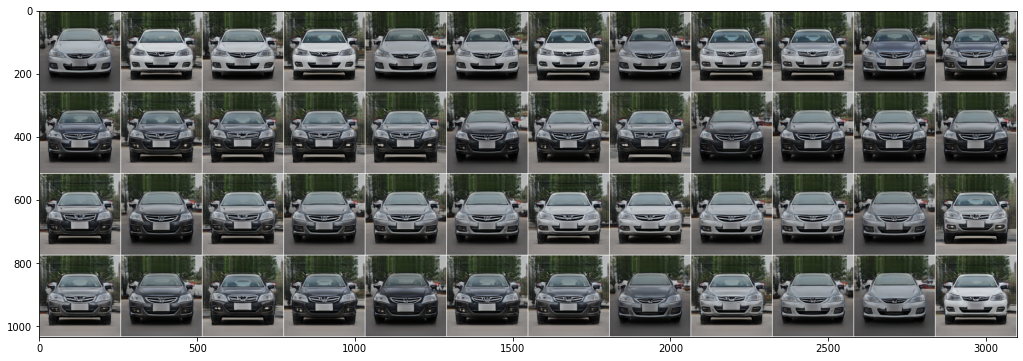

In [60]:
imgs = out
img_n_steps = 48
n_steps, batch_size = imgs.shape[:2]

# select img_n_steps points in range(n_steps*n_samples)
idx_paper = np.linspace(
    0, n_steps - n_steps // img_n_steps, img_n_steps
).astype(np.int)

# get the first batch
_imgs = imgs[idx_paper, 0]
img_grid = torchvision.utils.make_grid(
    _imgs, nrow=img_n_steps // 4, pad_value=1.
)
plt.figure(figsize=(20,6))
plt.imshow(img_grid.numpy().transpose(1,2,0))
None

### What does GIRAFFE model dataflow look like?

`GIRAFFE` => `DCDiscriminator`, `Generator`, test copy of `Generator`.

`GIRAFFE.forward()` calls `Generator.forward()`

`Generator` => `Decoder`, `Decoder` for background, `BoundingBoxGenerator` and `NeuralRenderer`.

`Generator.forward()` does:

1. `self.get_latent_codes()` samples latent variables from normal distribution if they have not been passed as argument.
2. similarly sample camera matrices, tranformations and rotations if they have not been passed as arguments.
3. `self.volumn_render_image()`
4. `NeuralRenderer.forward()`

`Generator.volumn_render_image()` does:

1. finds pixel and origin coordinates in world reference. Computes ray vector.
2. computes step sizes `di` for sampling along ray and integration of ray.
3. for each entity (foreground objects and background) do
    - `self.get_evaluation_points()` to get ray and point coordinates to sample entity color and density from.
    - `Decoder.forward()` to get sample entity color and density.
4. If `self.sample_object_existance` is true (not in our case), then use `self.get_object_existance()` ...etc to make some objects invisible for variable number of objects generation.
5. `self.composite_function()` to combine color and density from entities.
6. `self.calc_volume_weights()` to integrate color and density.
7. finishing tasks of creating hidden 2D image feature to send to `NeuralRenderer`.

Given the output of `Generator.volumn_render_image()`, `NeuralRenderer.forward()` does:

1. `self.conv_in` is an identity map
2. `self.use_rgb_skip` is true so use so do compositions of the operations
    - `Conv2d(X, 3, kernel_size=3, stride=1, padding=1)`. If this is done in the intermediate layers than add it to the output as residual.
    - bilinear upsampling by factor 2 and blur.
    - `Conv2d(X, X / 2, kernel_size=3, stride=1, padding=1)`.
    - Leaky ReLU activations with 0.2 leak.
3. final sigmoid activation

`im2scene.common.arange_pixels()` produces pixel coordinates.  
`im2scene.common.image_points_to_world()` projects pixel coordinates to world coordinates based on camera matrix and world matrix. This uses `transform_to_world()`.


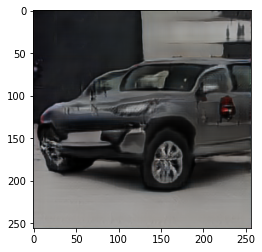

In [107]:
# calling the Generator
batch_size = 1
# out has shape (1, 3, 256, 256)
out = gen(batch_size)

img = out[0]
plt.figure(figsize=(4,4))
plt.imshow(img.cpu().detach().numpy().transpose(1,2,0))
None

In [109]:
latent_codes = gen.get_latent_codes(batch_size)

In [110]:
camera_matrices = gen.get_random_camera(batch_size)

In [111]:
transformations = gen.get_random_transformations(batch_size)

In [112]:
bg_rotation = gen.get_random_bg_rotation(batch_size)

In [118]:
it = 0
# rgb_v has shape (batch size, 256, 16, 16)
rgb_v = gen.volume_render_image(
    latent_codes, camera_matrices,
    transformations, bg_rotation,
    mode="val", it=it,
    not_render_background=False,
    only_render_background=False)

In [120]:
# out has shape (1, 3, 256, 256)
out = gen.neural_renderer(rgb_v)

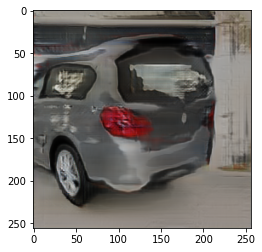

In [122]:
img = out[0]
plt.figure(figsize=(4,4))
plt.imshow(img.cpu().detach().numpy().transpose(1,2,0))
None

### Render add multiple

In [6]:
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

In [9]:
# body of renderer.render_add_objects_cars5()

# sample temperature; only used for visualiations
sample_tmp = 0.65
batch_size = 1
n_samples = 6
n_steps = 32

# Get values
z_shape_obj, z_app_obj, z_shape_bg, z_app_bg = gen.get_latent_codes(
    batch_size, tmp=sample_tmp)
z_shape_obj = gen.sample_z(
    z_shape_obj[:, :1].repeat(1, 6, 1).shape, tmp=sample_tmp)
z_app_obj = gen.sample_z(
    z_app_obj[:, :1].repeat(1, 6, 1).shape, tmp=sample_tmp)
bg_rotation = gen.get_random_bg_rotation(batch_size)
camera_matrices = gen.get_camera(val_v=0., batch_size=batch_size)

s = [
    [-1., -1., -1.],
    [-1., -1., -1.],
    [-1., -1., -1.],
    [-1., -1., -1.],
    [-1., -1., -1.],
    [-1., -1., -1.],
]

t = [
    [-0.7, -.8, 0.],
    [-0.7, 0.5, 0.],
    [-0.7, 1.8, 0.],
    [1.5, -.8, 0.],
    [1.5, 0.5, 0.],
    [1.5, 1.8, 0.],
]
r = [
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
]
outs = []
for i in range(1, 7):
    transformations = gen.get_transformations(
        s[:i], t[:i], r[:i], batch_size)
    latent_codes = [z_shape_obj[:, :i], z_app_obj[:, :i], z_shape_bg,
                    z_app_bg]
    with torch.no_grad():
        out = gen(
            batch_size, latent_codes, camera_matrices, transformations,
            bg_rotation, mode='val').cpu()
    outs.append(out)
outs = torch.stack(outs)


"""Saving process looks like this:

idx = torch.arange(6).reshape(-1, 1).repeat(1, (128 // 6)).reshape(-1)
outs = outs[[idx]]

out_folder = join(img_out_path, 'add_cars')
makedirs(out_folder, exist_ok=True)
self.save_video_and_images(outs, out_folder, name='add_cars',
                           is_full_rotation=False, add_reverse=True)
"""
None

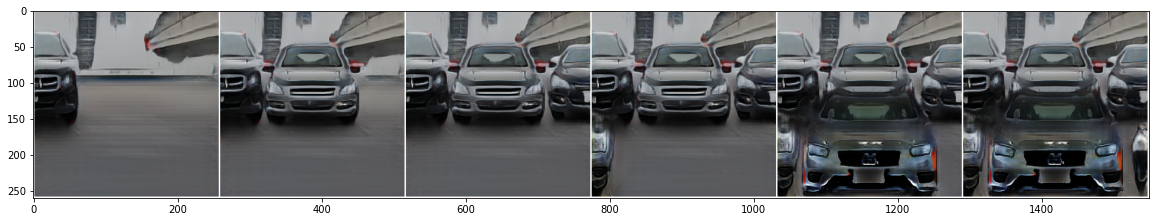

In [10]:
imgs = outs[:, 0]

img_grid = torchvision.utils.make_grid(
    imgs, nrow=6, pad_value=1.
)
plt.figure(figsize=(20,6))
plt.imshow(img_grid.numpy().transpose(1,2,0))
None

### Render custom compose